In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]


osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())


                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Name: count, dtype: int64


In [4]:
knee_osteoporosis_df.shape

(1573, 2)

In [5]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1258, 2)
(472, 2)
(315, 2)
(1101, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1258 validated image filenames belonging to 2 classes.
Found 472 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

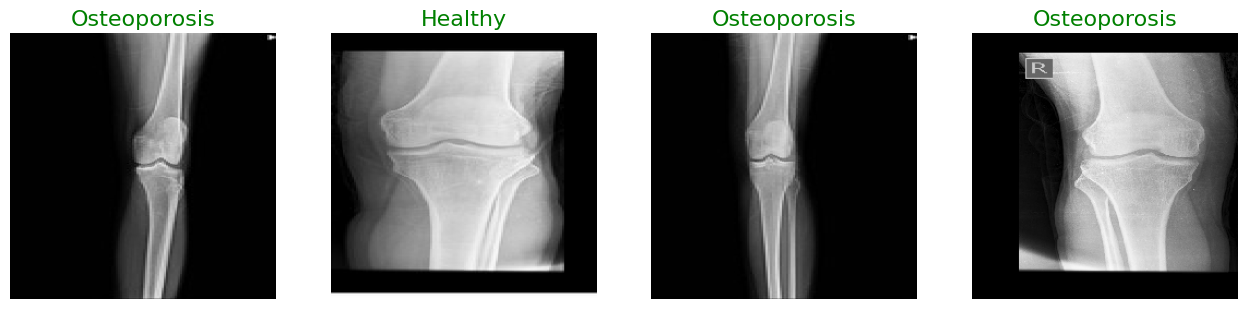

In [10]:
show_knee_images(train)

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.models import Model
from keras.applications.vgg19 import VGG19
import tensorflow as tf

vgg19_weights = '/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the custom model by adding layers
x = vgg19_model.output

# Add your custom layers according to your specified architecture
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x) 
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x) 
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)

x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)

output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=vgg19_model.input, outputs=output)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10


2025-02-12 04:42:14.864909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


315/315 [==============================] - 47s 124ms/step - loss: 0.6935 - accuracy: 0.4913 - val_loss: 0.6895 - val_accuracy: 0.4762
Epoch 2/10
315/315 [==============================] - 28s 87ms/step - loss: 0.6936 - accuracy: 0.5159 - val_loss: 0.6878 - val_accuracy: 0.4762
Epoch 3/10
315/315 [==============================] - 27s 86ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6878 - val_accuracy: 0.4762
Epoch 4/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6929 - accuracy: 0.5159 - val_loss: 0.6887 - val_accuracy: 0.4762
Epoch 5/10
315/315 [==============================] - 27s 86ms/step - loss: 0.6930 - accuracy: 0.5127 - val_loss: 0.6882 - val_accuracy: 0.4762
Epoch 6/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6925 - accuracy: 0.5111 - val_loss: 0.6879 - val_accuracy: 0.4762
Epoch 7/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6925 - accuracy: 0.5111 - val_loss: 0.6871 - val_accuracy: 0.4762
Ep

In [13]:
history1 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 88ms/step - loss: 0.6871 - accuracy: 0.5127 - val_loss: 0.6810 - val_accuracy: 0.5365
Epoch 2/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6824 - accuracy: 0.5199 - val_loss: 0.6746 - val_accuracy: 0.6381
Epoch 3/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6731 - accuracy: 0.5660 - val_loss: 0.6640 - val_accuracy: 0.6508
Epoch 4/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6607 - accuracy: 0.6256 - val_loss: 0.6766 - val_accuracy: 0.5746
Epoch 5/10
315/315 [==============================] - 28s 87ms/step - loss: 0.6497 - accuracy: 0.6574 - val_loss: 0.6479 - val_accuracy: 0.6540
Epoch 6/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6328 - accuracy: 0.6749 - val_loss: 0.6360 - val_accuracy: 0.6603
Epoch 7/10
315/315 [==============================] - 27s 87ms/step - loss: 0.6201 - accuracy: 0.7258 - val_loss: 0.6118 - val_accuracy:

In [14]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.5325 - accuracy: 0.7648


[0.5325183868408203, 0.7648305296897888]

In [15]:
history2 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 27s 87ms/step - loss: 0.5542 - accuracy: 0.7329 - val_loss: 0.5399 - val_accuracy: 0.7429
Epoch 2/10
315/315 [==============================] - 27s 87ms/step - loss: 0.5330 - accuracy: 0.7512 - val_loss: 0.5441 - val_accuracy: 0.7238
Epoch 3/10
315/315 [==============================] - 27s 87ms/step - loss: 0.5195 - accuracy: 0.7631 - val_loss: 0.5311 - val_accuracy: 0.7397
Epoch 4/10
315/315 [==============================] - 27s 87ms/step - loss: 0.5077 - accuracy: 0.7663 - val_loss: 0.5289 - val_accuracy: 0.7365
Epoch 5/10
315/315 [==============================] - 27s 87ms/step - loss: 0.5102 - accuracy: 0.7742 - val_loss: 0.5205 - val_accuracy: 0.7492
Epoch 6/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4997 - accuracy: 0.7766 - val_loss: 0.5066 - val_accuracy: 0.7492
Epoch 7/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4912 - accuracy: 0.7798 - val_loss: 0.5079 - val_accuracy:

In [16]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.4846 - accuracy: 0.7754


[0.48457789421081543, 0.7754237055778503]

In [17]:
history3 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4785 - accuracy: 0.7862 - val_loss: 0.5026 - val_accuracy: 0.7587
Epoch 2/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4694 - accuracy: 0.7917 - val_loss: 0.5901 - val_accuracy: 0.7238
Epoch 3/10
315/315 [==============================] - 27s 86ms/step - loss: 0.4659 - accuracy: 0.7893 - val_loss: 0.4732 - val_accuracy: 0.7683
Epoch 4/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4507 - accuracy: 0.8052 - val_loss: 0.4934 - val_accuracy: 0.7905
Epoch 5/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4491 - accuracy: 0.8005 - val_loss: 0.4743 - val_accuracy: 0.7810
Epoch 6/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4528 - accuracy: 0.7901 - val_loss: 0.4763 - val_accuracy: 0.7492
Epoch 7/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4434 - accuracy: 0.8060 - val_loss: 0.4930 - val_accuracy:

In [18]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 45ms/step - loss: 0.6680 - accuracy: 0.6737


[0.6679831743240356, 0.6737288236618042]

In [19]:
history4 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4136 - accuracy: 0.8227 - val_loss: 0.4257 - val_accuracy: 0.8000
Epoch 2/10
315/315 [==============================] - 27s 87ms/step - loss: 0.4065 - accuracy: 0.8299 - val_loss: 0.4816 - val_accuracy: 0.7683
Epoch 3/10
315/315 [==============================] - 27s 87ms/step - loss: 0.3855 - accuracy: 0.8347 - val_loss: 0.4188 - val_accuracy: 0.8032
Epoch 4/10
315/315 [==============================] - 27s 87ms/step - loss: 0.3851 - accuracy: 0.8323 - val_loss: 0.4154 - val_accuracy: 0.8095
Epoch 5/10
315/315 [==============================] - 28s 87ms/step - loss: 0.3702 - accuracy: 0.8450 - val_loss: 0.4060 - val_accuracy: 0.8159
Epoch 6/10
315/315 [==============================] - 27s 87ms/step - loss: 0.3686 - accuracy: 0.8402 - val_loss: 0.3937 - val_accuracy: 0.8381
Epoch 7/10
315/315 [==============================] - 27s 87ms/step - loss: 0.3426 - accuracy: 0.8601 - val_loss: 0.3815 - val_accuracy:

In [20]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.3443 - accuracy: 0.8602


[0.344341516494751, 0.8601694703102112]

In [21]:
history5 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 87ms/step - loss: 0.3060 - accuracy: 0.8760 - val_loss: 0.3305 - val_accuracy: 0.8413
Epoch 2/10
315/315 [==============================] - 27s 87ms/step - loss: 0.2808 - accuracy: 0.8871 - val_loss: 0.3264 - val_accuracy: 0.8540
Epoch 3/10
315/315 [==============================] - 28s 88ms/step - loss: 0.2661 - accuracy: 0.8935 - val_loss: 0.3199 - val_accuracy: 0.8730
Epoch 4/10
315/315 [==============================] - 28s 87ms/step - loss: 0.2722 - accuracy: 0.8943 - val_loss: 0.3522 - val_accuracy: 0.8444
Epoch 5/10
315/315 [==============================] - 27s 86ms/step - loss: 0.2511 - accuracy: 0.8951 - val_loss: 0.3439 - val_accuracy: 0.8413
Epoch 6/10
315/315 [==============================] - 27s 87ms/step - loss: 0.2323 - accuracy: 0.9046 - val_loss: 0.3352 - val_accuracy: 0.8286
Epoch 7/10
315/315 [==============================] - 27s 87ms/step - loss: 0.2506 - accuracy: 0.8911 - val_loss: 0.3086 - val_accuracy:

In [22]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.2582 - accuracy: 0.8877


[0.2582026422023773, 0.8877118825912476]

In [23]:
history6 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 27s 87ms/step - loss: 0.2024 - accuracy: 0.9165 - val_loss: 0.2478 - val_accuracy: 0.8921
Epoch 2/10
315/315 [==============================] - 28s 87ms/step - loss: 0.1855 - accuracy: 0.9253 - val_loss: 0.2416 - val_accuracy: 0.8825
Epoch 3/10
315/315 [==============================] - 27s 87ms/step - loss: 0.1540 - accuracy: 0.9324 - val_loss: 0.2434 - val_accuracy: 0.8921
Epoch 4/10
315/315 [==============================] - 27s 87ms/step - loss: 0.1641 - accuracy: 0.9356 - val_loss: 0.2572 - val_accuracy: 0.8825
Epoch 5/10
315/315 [==============================] - 27s 87ms/step - loss: 0.1529 - accuracy: 0.9436 - val_loss: 0.2169 - val_accuracy: 0.8984
Epoch 6/10
315/315 [==============================] - 27s 87ms/step - loss: 0.1448 - accuracy: 0.9428 - val_loss: 0.1980 - val_accuracy: 0.9079
Epoch 7/10
315/315 [==============================] - 27s 87ms/step - loss: 0.1311 - accuracy: 0.9499 - val_loss: 0.2631 - val_accuracy:

In [24]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1741 - accuracy: 0.9280


[0.17408041656017303, 0.9279661178588867]

In [25]:
history7 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.1177 - accuracy: 0.9483 - val_loss: 0.2042 - val_accuracy: 0.9175
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.1213 - accuracy: 0.9531 - val_loss: 0.1743 - val_accuracy: 0.9206
Epoch 3/5
315/315 [==============================] - 28s 87ms/step - loss: 0.1408 - accuracy: 0.9364 - val_loss: 0.1898 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.1121 - accuracy: 0.9539 - val_loss: 0.1690 - val_accuracy: 0.9206
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.1054 - accuracy: 0.9507 - val_loss: 0.1748 - val_accuracy: 0.9270


In [26]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1504 - accuracy: 0.9386


[0.15035158395767212, 0.9385592937469482]

In [27]:
history8 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.1814 - accuracy: 0.9340 - val_loss: 0.2656 - val_accuracy: 0.9048
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.1070 - accuracy: 0.9507 - val_loss: 0.2654 - val_accuracy: 0.8921
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.1094 - accuracy: 0.9555 - val_loss: 0.1698 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.1048 - accuracy: 0.9555 - val_loss: 0.2204 - val_accuracy: 0.9238
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0824 - accuracy: 0.9626 - val_loss: 0.1557 - val_accuracy: 0.9206


In [28]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1286 - accuracy: 0.9343


[0.1286010593175888, 0.9343220591545105]

In [29]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9513-01813.h5")

In [30]:
history8 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 87ms/step - loss: 0.1020 - accuracy: 0.9634 - val_loss: 0.2001 - val_accuracy: 0.9143
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0867 - accuracy: 0.9603 - val_loss: 0.1506 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 28s 87ms/step - loss: 0.1534 - accuracy: 0.9452 - val_loss: 0.1774 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0932 - accuracy: 0.9595 - val_loss: 0.1536 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0746 - accuracy: 0.9658 - val_loss: 0.2068 - val_accuracy: 0.9206


In [31]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.2032 - accuracy: 0.9280


[0.20322921872138977, 0.9279661178588867]

In [32]:
history9 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.1444 - accuracy: 0.9404 - val_loss: 0.1959 - val_accuracy: 0.9143
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0719 - accuracy: 0.9658 - val_loss: 0.7182 - val_accuracy: 0.8952
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0696 - accuracy: 0.9634 - val_loss: 0.2053 - val_accuracy: 0.9079
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0669 - accuracy: 0.9658 - val_loss: 0.1723 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0591 - accuracy: 0.9714 - val_loss: 0.1651 - val_accuracy: 0.9238


In [33]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.1307 - accuracy: 0.9386


[0.1307438164949417, 0.9385592937469482]

In [34]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9406-01328.h5")

In [35]:
history10 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0612 - accuracy: 0.9674 - val_loss: 0.1453 - val_accuracy: 0.9270
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0618 - accuracy: 0.9714 - val_loss: 0.1472 - val_accuracy: 0.9333
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0602 - accuracy: 0.9674 - val_loss: 0.1692 - val_accuracy: 0.9397
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0609 - accuracy: 0.9698 - val_loss: 0.1728 - val_accuracy: 0.9143
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0596 - accuracy: 0.9674 - val_loss: 0.1616 - val_accuracy: 0.9397


In [36]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.1238 - accuracy: 0.9470


[0.12383462488651276, 0.9470338821411133]

In [37]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9406-01093.h5")

In [38]:
history11 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0604 - accuracy: 0.9698 - val_loss: 0.1802 - val_accuracy: 0.9175
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0794 - accuracy: 0.9658 - val_loss: 0.1571 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0546 - accuracy: 0.9730 - val_loss: 0.1615 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0811 - accuracy: 0.9626 - val_loss: 0.1428 - val_accuracy: 0.9206
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0758 - accuracy: 0.9634 - val_loss: 0.1311 - val_accuracy: 0.9302


In [39]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1043 - accuracy: 0.9428


[0.10426545888185501, 0.9427965879440308]

In [40]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9510-01134.h5")

In [41]:
history12 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0647 - accuracy: 0.9682 - val_loss: 0.2182 - val_accuracy: 0.9365
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0817 - accuracy: 0.9642 - val_loss: 0.3656 - val_accuracy: 0.8095
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0876 - accuracy: 0.9610 - val_loss: 0.6626 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0577 - accuracy: 0.9690 - val_loss: 0.7862 - val_accuracy: 0.9302
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0588 - accuracy: 0.9714 - val_loss: 0.1695 - val_accuracy: 0.9333


In [42]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.1249 - accuracy: 0.9470


[0.12488250434398651, 0.9470338821411133]

In [43]:
history12 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0527 - accuracy: 0.9730 - val_loss: 0.6775 - val_accuracy: 0.9302
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0653 - accuracy: 0.9642 - val_loss: 0.3163 - val_accuracy: 0.9016
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0611 - accuracy: 0.9698 - val_loss: 0.1865 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0485 - accuracy: 0.9730 - val_loss: 0.7101 - val_accuracy: 0.9333
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0508 - accuracy: 0.9690 - val_loss: 0.2189 - val_accuracy: 0.9270


In [44]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1412 - accuracy: 0.9428


[0.14116120338439941, 0.9427965879440308]

In [45]:
history13 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0480 - accuracy: 0.9682 - val_loss: 0.2773 - val_accuracy: 0.9302
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0513 - accuracy: 0.9706 - val_loss: 0.8450 - val_accuracy: 0.9302
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0490 - accuracy: 0.9730 - val_loss: 0.2217 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0477 - accuracy: 0.9714 - val_loss: 0.8002 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0491 - accuracy: 0.9706 - val_loss: 0.2918 - val_accuracy: 0.9238


In [46]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1264 - accuracy: 0.9428


[0.1264231652021408, 0.9427965879440308]

In [47]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9533-01016.h5")

In [48]:
history14 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0494 - accuracy: 0.9730 - val_loss: 0.8541 - val_accuracy: 0.9302
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0621 - accuracy: 0.9658 - val_loss: 1.0380 - val_accuracy: 0.9238
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0540 - accuracy: 0.9698 - val_loss: 0.1866 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0474 - accuracy: 0.9722 - val_loss: 0.2027 - val_accuracy: 0.9238
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0476 - accuracy: 0.9730 - val_loss: 0.2934 - val_accuracy: 0.9206


In [49]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 45ms/step - loss: 0.1451 - accuracy: 0.9407


[0.14510513842105865, 0.9406779408454895]

In [50]:
history15 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0484 - accuracy: 0.9722 - val_loss: 0.1882 - val_accuracy: 0.9238
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0459 - accuracy: 0.9738 - val_loss: 0.2394 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0468 - accuracy: 0.9698 - val_loss: 0.1986 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0478 - accuracy: 0.9730 - val_loss: 0.5169 - val_accuracy: 0.9238
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0460 - accuracy: 0.9714 - val_loss: 0.4732 - val_accuracy: 0.9206


In [51]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.1520 - accuracy: 0.9407


[0.15198294818401337, 0.9406779408454895]

In [52]:
history16 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0467 - accuracy: 0.9698 - val_loss: 0.2158 - val_accuracy: 0.9238
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0459 - accuracy: 0.9738 - val_loss: 0.2177 - val_accuracy: 0.9302
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0461 - accuracy: 0.9706 - val_loss: 0.3314 - val_accuracy: 0.9206
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0835 - accuracy: 0.9626 - val_loss: 0.3455 - val_accuracy: 0.9302
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0482 - accuracy: 0.9698 - val_loss: 0.4521 - val_accuracy: 0.9365


In [53]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.1338 - accuracy: 0.9513


[0.13376615941524506, 0.9512711763381958]

In [54]:
history17 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0469 - accuracy: 0.9714 - val_loss: 0.2182 - val_accuracy: 0.9238
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0487 - accuracy: 0.9730 - val_loss: 0.3212 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0474 - accuracy: 0.9714 - val_loss: 0.4934 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0462 - accuracy: 0.9730 - val_loss: 0.2585 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0456 - accuracy: 0.9722 - val_loss: 0.5038 - val_accuracy: 0.9270


In [55]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 45ms/step - loss: 0.1378 - accuracy: 0.9449


[0.13780416548252106, 0.944915235042572]

In [56]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9533-00959.h5")

In [57]:
history18 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0448 - accuracy: 0.9722 - val_loss: 0.3025 - val_accuracy: 0.9238
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0453 - accuracy: 0.9722 - val_loss: 0.2016 - val_accuracy: 0.9238
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0464 - accuracy: 0.9706 - val_loss: 0.3457 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0465 - accuracy: 0.9730 - val_loss: 0.3386 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0458 - accuracy: 0.9730 - val_loss: 0.4161 - val_accuracy: 0.9270


In [58]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1445 - accuracy: 0.9449


[0.14452694356441498, 0.944915235042572]

In [59]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9597-00927.h5")

In [60]:
history19 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0456 - accuracy: 0.9722 - val_loss: 0.2627 - val_accuracy: 0.9238
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0448 - accuracy: 0.9754 - val_loss: 0.4381 - val_accuracy: 0.9238
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0450 - accuracy: 0.9722 - val_loss: 0.3692 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0462 - accuracy: 0.9690 - val_loss: 0.2693 - val_accuracy: 0.9238
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0444 - accuracy: 0.9738 - val_loss: 0.3438 - val_accuracy: 0.9302


In [61]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.1513 - accuracy: 0.9470


[0.15131962299346924, 0.9470338821411133]

In [62]:
history20 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0474 - accuracy: 0.9730 - val_loss: 0.7505 - val_accuracy: 0.9143
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0525 - accuracy: 0.9706 - val_loss: 0.2725 - val_accuracy: 0.9238
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0480 - accuracy: 0.9722 - val_loss: 0.1939 - val_accuracy: 0.9302
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0470 - accuracy: 0.9722 - val_loss: 0.2191 - val_accuracy: 0.9238
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0455 - accuracy: 0.9722 - val_loss: 0.9883 - val_accuracy: 0.9333


In [63]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.1658 - accuracy: 0.9492


[0.16577906906604767, 0.9491525292396545]

In [64]:
history21 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0465 - accuracy: 0.9754 - val_loss: 0.1727 - val_accuracy: 0.9270
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0463 - accuracy: 0.9730 - val_loss: 0.5230 - val_accuracy: 0.9302
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0460 - accuracy: 0.9714 - val_loss: 0.1947 - val_accuracy: 0.9206
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0449 - accuracy: 0.9746 - val_loss: 0.8356 - val_accuracy: 0.9333
Epoch 5/5
315/315 [==============================] - 28s 87ms/step - loss: 0.0463 - accuracy: 0.9714 - val_loss: 0.4538 - val_accuracy: 0.9270


In [65]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.1407 - accuracy: 0.9428


[0.14066538214683533, 0.9427965879440308]

In [66]:
history22 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0448 - accuracy: 0.9738 - val_loss: 0.6822 - val_accuracy: 0.9270
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0445 - accuracy: 0.9746 - val_loss: 0.5820 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0443 - accuracy: 0.9738 - val_loss: 0.4745 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0436 - accuracy: 0.9714 - val_loss: 0.6195 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0450 - accuracy: 0.9762 - val_loss: 0.6979 - val_accuracy: 0.9270


In [67]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1527 - accuracy: 0.9428


[0.15274308621883392, 0.9427965879440308]

In [68]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9618-0854.h5")

In [69]:
history23 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 87ms/step - loss: 0.0431 - accuracy: 0.9722 - val_loss: 0.4172 - val_accuracy: 0.9270
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0456 - accuracy: 0.9730 - val_loss: 0.8380 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0439 - accuracy: 0.9738 - val_loss: 0.8033 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0445 - accuracy: 0.9714 - val_loss: 0.6860 - val_accuracy: 0.9238
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0441 - accuracy: 0.9730 - val_loss: 0.5841 - val_accuracy: 0.9270


In [70]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.1605 - accuracy: 0.9428


[0.1604757457971573, 0.9427965879440308]

In [71]:
history24 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0448 - accuracy: 0.9730 - val_loss: 0.7949 - val_accuracy: 0.9270
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0431 - accuracy: 0.9746 - val_loss: 0.6809 - val_accuracy: 0.9238
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0438 - accuracy: 0.9730 - val_loss: 0.7907 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0430 - accuracy: 0.9738 - val_loss: 0.7440 - val_accuracy: 0.9206
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0448 - accuracy: 0.9738 - val_loss: 0.7270 - val_accuracy: 0.9270


In [72]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.1584 - accuracy: 0.9449


[0.15841200947761536, 0.944915235042572]

In [73]:
history25 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0440 - accuracy: 0.9754 - val_loss: 0.6917 - val_accuracy: 0.9238
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0539 - accuracy: 0.9738 - val_loss: 0.2762 - val_accuracy: 0.9302
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0560 - accuracy: 0.9682 - val_loss: 0.2753 - val_accuracy: 0.9206
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0451 - accuracy: 0.9714 - val_loss: 0.1663 - val_accuracy: 0.9206
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0527 - accuracy: 0.9706 - val_loss: 0.1542 - val_accuracy: 0.9365


In [74]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1165 - accuracy: 0.9470


[0.11653595417737961, 0.9470338821411133]

In [75]:
history26 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0445 - accuracy: 0.9762 - val_loss: 0.1582 - val_accuracy: 0.9333
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0468 - accuracy: 0.9722 - val_loss: 0.6893 - val_accuracy: 0.9302
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0968 - accuracy: 0.9531 - val_loss: 0.5299 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0489 - accuracy: 0.9714 - val_loss: 0.7868 - val_accuracy: 0.9333
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.1660 - accuracy: 0.9316 - val_loss: 0.1526 - val_accuracy: 0.9333


In [76]:
history27 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0517 - accuracy: 0.9714 - val_loss: 0.2229 - val_accuracy: 0.9079
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0491 - accuracy: 0.9722 - val_loss: 0.1858 - val_accuracy: 0.9333
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0461 - accuracy: 0.9730 - val_loss: 0.1840 - val_accuracy: 0.9238
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0500 - accuracy: 0.9746 - val_loss: 0.1794 - val_accuracy: 0.9333
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0458 - accuracy: 0.9746 - val_loss: 0.1593 - val_accuracy: 0.9333


In [77]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1196 - accuracy: 0.9449


[0.11962894350290298, 0.944915235042572]

In [78]:
history28 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0458 - accuracy: 0.9746 - val_loss: 0.1664 - val_accuracy: 0.9333
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0449 - accuracy: 0.9738 - val_loss: 0.1754 - val_accuracy: 0.9365
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0449 - accuracy: 0.9730 - val_loss: 0.1783 - val_accuracy: 0.9333
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0440 - accuracy: 0.9746 - val_loss: 0.1928 - val_accuracy: 0.9333
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0440 - accuracy: 0.9746 - val_loss: 0.1970 - val_accuracy: 0.9333


In [79]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 45ms/step - loss: 0.1444 - accuracy: 0.9470


[0.14437918365001678, 0.9470338821411133]

In [80]:
history29 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 87ms/step - loss: 0.0436 - accuracy: 0.9754 - val_loss: 0.2107 - val_accuracy: 0.9302
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0427 - accuracy: 0.9730 - val_loss: 0.2224 - val_accuracy: 0.9333
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0416 - accuracy: 0.9746 - val_loss: 0.2352 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0413 - accuracy: 0.9746 - val_loss: 0.2268 - val_accuracy: 0.9333
Epoch 5/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0410 - accuracy: 0.9754 - val_loss: 0.2181 - val_accuracy: 0.9365


In [81]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 5s 46ms/step - loss: 0.1586 - accuracy: 0.9492


[0.15862420201301575, 0.9491525292396545]

In [82]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9682-00660.h5")

In [83]:
history30 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0408 - accuracy: 0.9762 - val_loss: 0.2321 - val_accuracy: 0.9270
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0409 - accuracy: 0.9762 - val_loss: 0.2298 - val_accuracy: 0.9238
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0408 - accuracy: 0.9738 - val_loss: 0.2293 - val_accuracy: 0.9302
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0408 - accuracy: 0.9762 - val_loss: 0.2375 - val_accuracy: 0.9238
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0404 - accuracy: 0.9769 - val_loss: 0.2330 - val_accuracy: 0.9302


In [84]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 46ms/step - loss: 0.1685 - accuracy: 0.9449


[0.1685091257095337, 0.944915235042572]

In [85]:
history31 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0411 - accuracy: 0.9762 - val_loss: 0.2280 - val_accuracy: 0.9333
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0402 - accuracy: 0.9746 - val_loss: 0.2361 - val_accuracy: 0.9302
Epoch 3/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0407 - accuracy: 0.9754 - val_loss: 0.2310 - val_accuracy: 0.9302
Epoch 4/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0406 - accuracy: 0.9754 - val_loss: 0.2795 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0406 - accuracy: 0.9762 - val_loss: 0.2528 - val_accuracy: 0.9270


In [86]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.1708 - accuracy: 0.9449


[0.17081303894519806, 0.944915235042572]

In [87]:
history32 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0401 - accuracy: 0.9762 - val_loss: 0.2410 - val_accuracy: 0.9302
Epoch 2/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0404 - accuracy: 0.9777 - val_loss: 0.2915 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0409 - accuracy: 0.9762 - val_loss: 0.2327 - val_accuracy: 0.9302
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0402 - accuracy: 0.9754 - val_loss: 0.2359 - val_accuracy: 0.9302
Epoch 5/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0406 - accuracy: 0.9746 - val_loss: 0.2453 - val_accuracy: 0.9270


In [88]:
history33 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0404 - accuracy: 0.9769 - val_loss: 0.2346 - val_accuracy: 0.9302
Epoch 2/5
315/315 [==============================] - 27s 86ms/step - loss: 0.0416 - accuracy: 0.9785 - val_loss: 0.2829 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0407 - accuracy: 0.9769 - val_loss: 0.2324 - val_accuracy: 0.9302
Epoch 4/5
315/315 [==============================] - 27s 87ms/step - loss: 0.0408 - accuracy: 0.9746 - val_loss: 0.2662 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 28s 87ms/step - loss: 0.0400 - accuracy: 0.9769 - val_loss: 0.2420 - val_accuracy: 0.9302


In [89]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1744 - accuracy: 0.9449


[0.17441974580287933, 0.944915235042572]

In [90]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9745-00681.h5")

In [91]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

118/118 [==============================] - 6s 46ms/step


In [92]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.96      0.92      0.94       231
Osteoporosis       0.93      0.97      0.95       241

    accuracy                           0.94       472
   macro avg       0.95      0.94      0.94       472
weighted avg       0.95      0.94      0.94       472

Accuracy of the Model: 94.5%


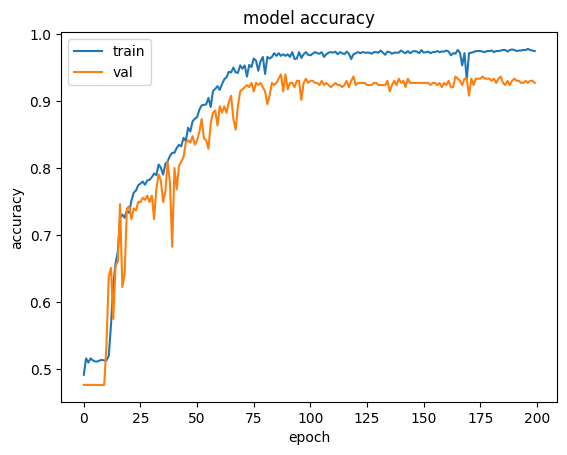

In [93]:
plt.plot(history.history["accuracy"] +
history1.history["accuracy"] +
history2.history["accuracy"] +
history3.history["accuracy"] +
history4.history["accuracy"] +
history5.history["accuracy"] +
history6.history["accuracy"] +
history7.history["accuracy"] +
history8.history["accuracy"] +
history9.history["accuracy"] +
history10.history["accuracy"] +
history11.history["accuracy"] +
history12.history["accuracy"] +
history13.history["accuracy"] +
history14.history["accuracy"] +
history15.history["accuracy"] +
history16.history["accuracy"] +
history17.history["accuracy"] +
history18.history["accuracy"] +
history19.history["accuracy"] +
history20.history["accuracy"] +
history21.history["accuracy"] +
history22.history["accuracy"] +
history23.history["accuracy"] +
history24.history["accuracy"] +
history25.history["accuracy"] +
history26.history["accuracy"] +
history27.history["accuracy"] +
history28.history["accuracy"] +
history29.history["accuracy"] +
history30.history["accuracy"] +
history31.history["accuracy"] +
history32.history["accuracy"])



plt.plot(history.history["val_accuracy"] +
history1.history["val_accuracy"] +
history2.history["val_accuracy"] +
history3.history["val_accuracy"] +
history4.history["val_accuracy"] +
history5.history["val_accuracy"] +
history6.history["val_accuracy"] +
history7.history["val_accuracy"] +
history8.history["val_accuracy"] +
history9.history["val_accuracy"] +
history10.history["val_accuracy"] +
history11.history["val_accuracy"] +
history12.history["val_accuracy"] +
history13.history["val_accuracy"] +
history14.history["val_accuracy"] +
history15.history["val_accuracy"] +
history16.history["val_accuracy"] +
history17.history["val_accuracy"] +
history18.history["val_accuracy"] +
history19.history["val_accuracy"] +
history20.history["val_accuracy"] +
history21.history["val_accuracy"] +
history22.history["val_accuracy"] +
history23.history["val_accuracy"] +
history24.history["val_accuracy"] +
history25.history["val_accuracy"] +
history26.history["val_accuracy"] +
history27.history["val_accuracy"] +
history28.history["val_accuracy"] +
history29.history["val_accuracy"] +
history30.history["val_accuracy"] +
history31.history["val_accuracy"] +
history32.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

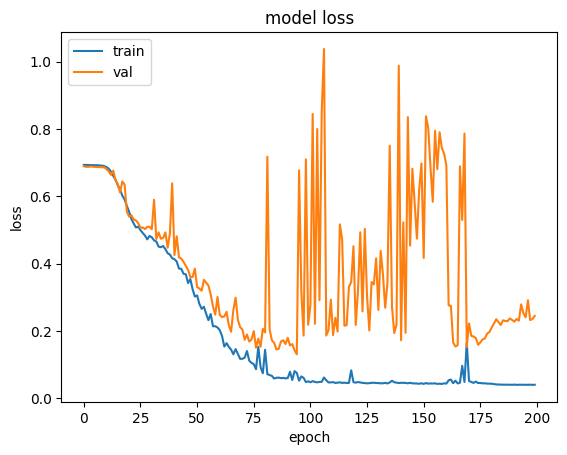

In [94]:
plt.plot(history.history["loss"] +
history1.history["loss"] +
history2.history["loss"] +
history3.history["loss"] +
history4.history["loss"] +
history5.history["loss"] +
history6.history["loss"] +
history7.history["loss"] +
history8.history["loss"] +
history9.history["loss"] +
history10.history["loss"] +
history11.history["loss"] +
history12.history["loss"] +
history13.history["loss"] +
history14.history["loss"] +
history15.history["loss"] +
history16.history["loss"] +
history17.history["loss"] +
history18.history["loss"] +
history19.history["loss"] +
history20.history["loss"] +
history21.history["loss"] +
history22.history["loss"] +
history23.history["loss"] +
history24.history["loss"] +
history25.history["loss"] +
history26.history["loss"] +
history27.history["loss"] +
history28.history["loss"] +
history29.history["loss"] +
history30.history["loss"] +
history31.history["loss"] +
history32.history["loss"])


plt.plot(history.history["val_loss"] +
history1.history["val_loss"] +
history2.history["val_loss"] +
history3.history["val_loss"] +
history4.history["val_loss"] +
history5.history["val_loss"] +
history6.history["val_loss"] +
history7.history["val_loss"] +
history8.history["val_loss"] +
history9.history["val_loss"] +
history10.history["val_loss"] +
history11.history["val_loss"] +
history12.history["val_loss"] +
history13.history["val_loss"] +
history14.history["val_loss"] +
history15.history["val_loss"] +
history16.history["val_loss"] +
history17.history["val_loss"] +
history18.history["val_loss"] +
history19.history["val_loss"] +
history20.history["val_loss"] +
history21.history["val_loss"] +
history22.history["val_loss"] +
history23.history["val_loss"] +
history24.history["val_loss"] +
history25.history["val_loss"] +
history26.history["val_loss"] +
history27.history["val_loss"] +
history28.history["val_loss"] +
history29.history["val_loss"] +
history30.history["val_loss"] +
history31.history["val_loss"] +
history32.history["val_loss"])


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

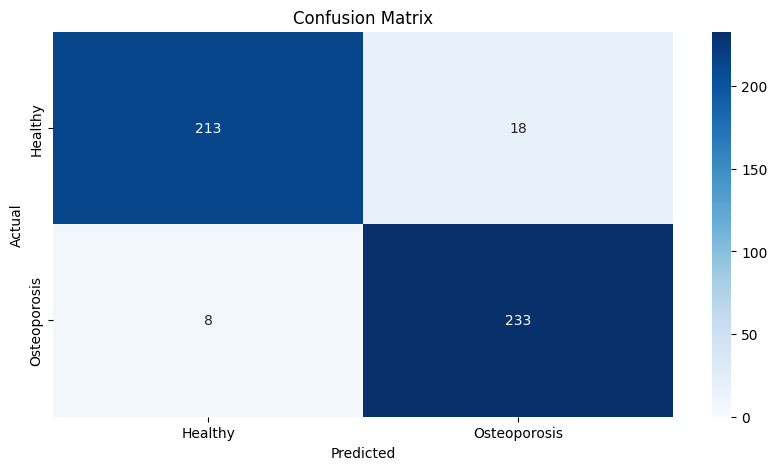

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


In [98]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('osteoporosisEEEEEEEEEEEEEEbinary-9618-0854.h5')


In [99]:
import os
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS31.jpg'



In [100]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)  # Read the image
    image_resized = cv2.resize(image, target_size)  # Resize the image
    image_normalized = image_resized / 255.0  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=0)  # Add batch dimension


In [103]:
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS11.jpg'

try:
    # Preprocess the image
    image_ready = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(image_ready)
    
    # Store the result
    results = [{'Filename': os.path.basename(image_path), 'Prediction': prediction[0]}]
    print(results)
except Exception as e:
    print(f"Error processing the image: {e}")


1/1 [==============================] - 0s 19ms/step
[{'Filename': 'OS11.jpg', 'Prediction': array([7.4788346e-08, 9.9999976e-01], dtype=float32)}]


1/1 [==============================] - 0s 20ms/step


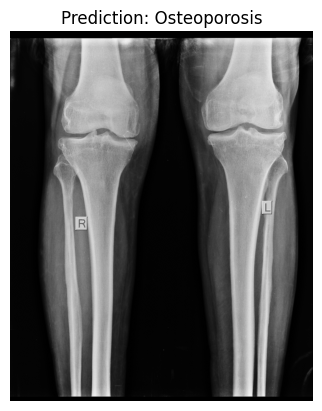

In [104]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define class labels (adjust based on your model's classes)
class_labels = ["Healthy", "Osteoporosis"]  # Modify as needed

# Attempt to read the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to load the image at {image_path}")
else:
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image (if not already done in the pipeline)
    image_ready = preprocess_image(image_path)  # Ensure this function is defined

    # Run the prediction
    prediction = model.predict(image_ready)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)  # Use argmax for multiclass models
    predicted_class = class_labels[predicted_class_index]

    # Display the image with the predicted class
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()


In [105]:
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal/N20.jpg'

try:
    # Preprocess the image
    image_ready = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(image_ready)
    
    # Store the result
    results = [{'Filename': os.path.basename(image_path), 'Prediction': prediction[0]}]
    print(results)
except Exception as e:
    print(f"Error processing the image: {e}")


1/1 [==============================] - 0s 18ms/step
[{'Filename': 'N20.jpg', 'Prediction': array([1., 0.], dtype=float32)}]


1/1 [==============================] - 0s 19ms/step


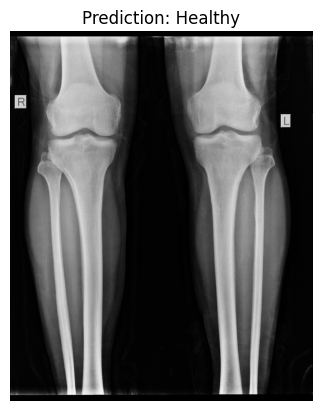

In [106]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define class labels (adjust based on your model's classes)
class_labels = ["Healthy", "Osteoporosis"]  # Modify as needed

# Attempt to read the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to load the image at {image_path}")
else:
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image (if not already done in the pipeline)
    image_ready = preprocess_image(image_path)  # Ensure this function is defined

    # Run the prediction
    prediction = model.predict(image_ready)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)  # Use argmax for multiclass models
    predicted_class = class_labels[predicted_class_index]

    # Display the image with the predicted class
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()
